# I. Introduction

## A. Objective
The main objective of this analysis is to evaluate the performance of linear regression models in predicting the mortality rate based on various features and to understand the importance of each feature in the model.
This research is a part of a series of trials of different ML models.

## B. Dataset Description
The dataset consists of the following features:
1. Age
1. HBR (b)
1. Systolic AP(b)
1. Creatine in blood
1. EF Percentage
1. White blood cells count
1. Glucose
1. CHF KiLLip_0.0
1. CHF KiLLip_1.0
1. CHF KiLLip_2.0
1. CHF KiLLip_3.0
1. CHF KiLLip_4.0

# II. Import Necessary Libraries

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# III. Load Data

In [11]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared_KiLLip_encoded.csv')

# IV. Splitting the Data

In [12]:
X_global = ready_data.drop('Class', axis=1)
y_global = ready_data['Class']

We want to have more control over hyper parameters, so we will examine three different random_state values. 

In [13]:
random_states = [0, 25, 42]

# V. Linear Regression Model

## A. Single Variable Regression

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from typing import List, Tuple

In [15]:
# Initial split to hold out a test set
X_global_train, X_global_test, y_global_train, y_global_test = train_test_split(X_global, y_global, test_size=0.2, random_state=0, stratify=y_global)

In [41]:
def evaluate_random_states(X: pd.DataFrame, y: pd.Series, random_states: List[int]) -> Tuple[int, float]:
    """
    Evaluate models with different random states and returns the random state of the best model based on mean R2 score.
    """
    best_r2 = -np.inf
    best_state = None

    for state in random_states:
        # Split the data using Stratified K-Fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
        
        r2_scores = []  # List to hold R2 scores across all features for this random state

        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Univariate linear regression for each feature
        for feature in X.columns:
            model = LinearRegression()
            # Use cross_val_score with the Stratified K-Fold object
            scores = cross_val_score(model,
                                     X_scaled[:, X.columns.get_loc(feature)].reshape(-1, 1),
                                     y,
                                     scoring="r2",
                                     cv=skf,
                                     n_jobs=-1)
            r2_scores.append(np.mean(scores))

        # Update best random state if current mean R2 is better
        current_r2 = np.mean(r2_scores)
        print(f"Random state={state}; r2={current_r2:.6f}")
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_state = state

    return best_state, best_r2


### 1. Analyzing Random State Effect
Evaluating the effect of different random states on the model performance to understand the stability of the model.

In [42]:
# Find the best random state from the initial training set
best_state, _ = evaluate_random_states(X_global_train, y_global_train, random_states=random_states)

Random state=0; r2=0.022590
Random state=25; r2=0.022489
Random state=42; r2=0.022512


In [36]:
# Now split the initial training set again using the best random state
X_train, X_test, y_train, y_test = train_test_split(X_global_train, y_global_train, test_size=0.2, random_state=best_state, stratify=y_global_train)

In [35]:
def compute_feature_importance_and_coefficients(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> pd.DataFrame:
    """
    Compute feature importances and coefficients for the provided training and testing data.
    """
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    importances = []
    coefficients = []

    # Univariate linear regression for each feature
    for feature in X_train.columns:
        model = LinearRegression()
        model.fit(X_train_scaled[:, X_train.columns.get_loc(feature)].reshape(-1, 1), y_train)
        # Use cross_val_score with the best random state
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=best_state)
        scores = cross_val_score(model,
                                 X_test_scaled[:, X_train.columns.get_loc(feature)].reshape(-1, 1),
                                 y_test,
                                 scoring="r2",
                                 cv=skf,
                                 n_jobs=-1)
        importances.append(np.mean(scores))
        coefficients.append(model.coef_[0])

    # Create a DataFrame to hold the importances and coefficients
    feature_importances = pd.DataFrame(index=X_train.columns)
    feature_importances['Mean Importance'] = importances
    feature_importances['Mean Coef'] = coefficients

    return feature_importances

In [34]:
feature_names = ["Age", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", 
                 "White blood cells count", "Glucose", "CHF KiLLip_0.0", "CHF KiLLip_1.0", 
                 "CHF KiLLip_2.0", "CHF KiLLip_3.0", "CHF KiLLip_4.0"]
feature_importances = pd.DataFrame(index=feature_names)

# Compute feature importances and coefficients using the best model
feature_importances = compute_feature_importance_and_coefficients(X_train, y_train, X_test, y_test)


print(f"Best Random State: {best_state}")

Best Random State: 0


### 2. Feature Importance Analysis

In [27]:
feature_importances # Calculated on a global train set

,Mean Importance,Mean Coef
Age,0.002254,0.019805
HBR (b),0.005750,0.037706
Systolic AP(b),0.032077,-0.021157
Creatinine in blood,0.015221,0.036615
EF Percentage,0.009754,-0.047555
White blood cells count,0.023220,0.025765
Glucose,-0.065171,0.044338
CHF KiLLip_0.0,-0.000976,-0.001097
CHF KiLLip_1.0,0.011896,-0.026622
CHF KiLLip_2.0,-0.003297,0.002686


### 3. Plotting features' weights and coefficients

In [91]:
def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    plt.style.use('seaborn-v0_8-talk')  # Applying the style
    palette = sns.color_palette("husl", 2)  # Defining the color palette
    
    barWidth = 0.45

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color=palette[0], height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color=palette[1], height=barWidth, edgecolor='grey', label=label2)
   
    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index, fontsize=10)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            if width >= 0:
                h_align = 'left'  # Horizontal alignment
                padding = 0.001  # Adjust this value to position the text to the right of the bar
            else:
                h_align = 'right' 
                padding = -0.000001  # Adjust this value to position the text to the left of the bar
        
            # The text will be positioned at the end of the bar (if positive) or at the start of the bar (if negative)
            plt.text(width + padding,               
                    bar.get_y() + bar.get_height() / 2.5 ,  
                    f"{width :.{num_digits}f}",  
                    ha=h_align, va='center', fontsize=10)

    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

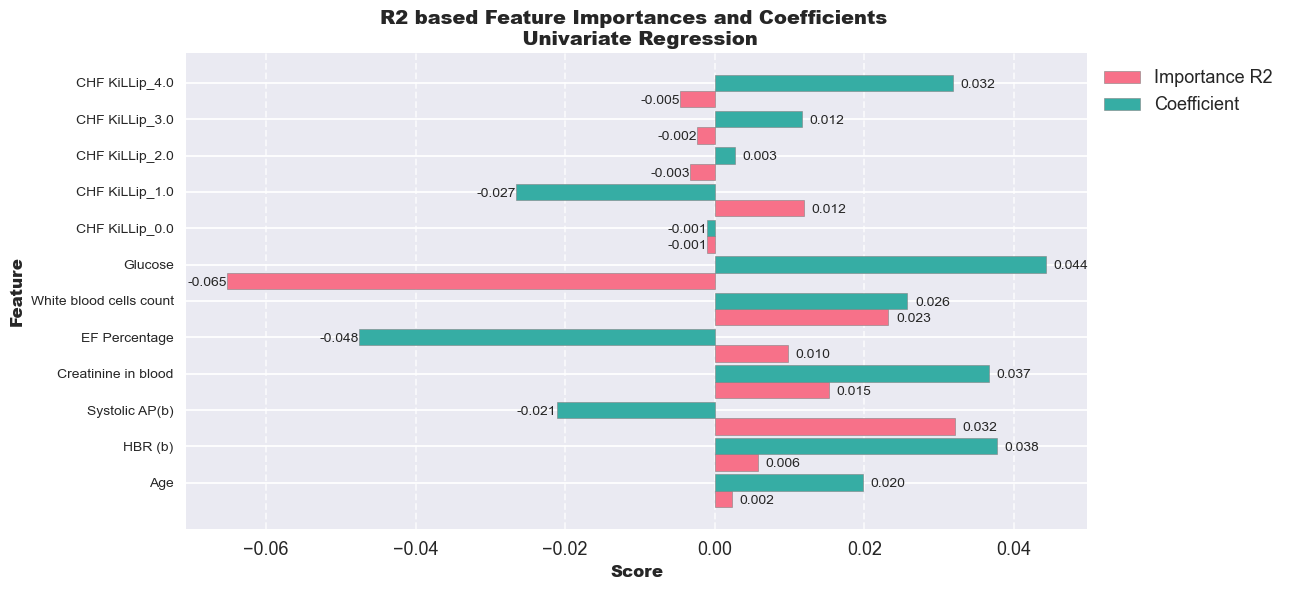

In [92]:
plot_weights(feature_importances, 'Mean Importance', 'Mean Coef', label1='Importance R2', label2='Coefficient', 
            title='R2 based Feature Importances and Coefficients \n Univariate Regression' )

## B. Multivariate linear regression
### 1. Analyzing Random State Effect and choosing the best model

In [93]:
# Dictionary to hold the r2 score and model for each random state
r2_scores = {}
models = {}

for state in random_states:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
    X_train, X_test, y_train, y_test = train_test_split(X_global_train, y_global_train, test_size=0.2, random_state=state, stratify=y_global_train)
    
    model = LinearRegression(fit_intercept=True, n_jobs=-1)
    model.fit(X_train, y_train)

    scores = cross_val_score(model, X_test, y_test, scoring="r2", cv=skf)
    print(f"Mean cross-validation score: {np.mean(scores): .4f} for {state=}")

    # Save the model and r2 score
    r2_scores[state] = np.mean(scores)
    models[state] = model

# Find the random state with the highest r2 score
best_random_state = max(r2_scores, key=r2_scores.get)
best_model = models[best_random_state]

additional_test_score = best_model.score(X_global_test, y_global_test)
print(f"The best random state is {best_random_state} with an r2 score of {r2_scores[best_random_state]: .4f} on the validation set and {additional_test_score: .4f} on the additional test set.")


Mean cross-validation score: -0.0136 for state=0
Mean cross-validation score:  0.1063 for state=25
Mean cross-validation score:  0.0546 for state=42
The best random state is 25 with an r2 score of  0.1063 on the validation set and  0.1211 on the additional test set.


### 2. Feature Importance Analysis

In [94]:
import shap

feature_importances_multi = pd.DataFrame(index=feature_names)

explainer = shap.Explainer(best_model, X_global_train)
shap_values = explainer(X_global_test)

feature_importances_multi["Coef"] = model.coef_
feature_importances_multi["Mean shap values"] = np.mean(np.abs(shap_values.values), axis=0)


In [95]:
feature_importances_multi

,Coef,Mean shap values
Age,0.000438,0.004137
HBR (b),0.001313,0.016665
Systolic AP(b),-0.000417,0.006555
Creatinine in blood,0.000494,0.015274
EF Percentage,-0.003804,0.023095
White blood cells count,0.001394,0.004224
Glucose,0.010942,0.013020
CHF KiLLip_0.0,-0.041043,0.000197
CHF KiLLip_1.0,-0.011025,0.004802
CHF KiLLip_2.0,-0.010743,0.000456


### 3. Plotting features' SHAP values and coefficients

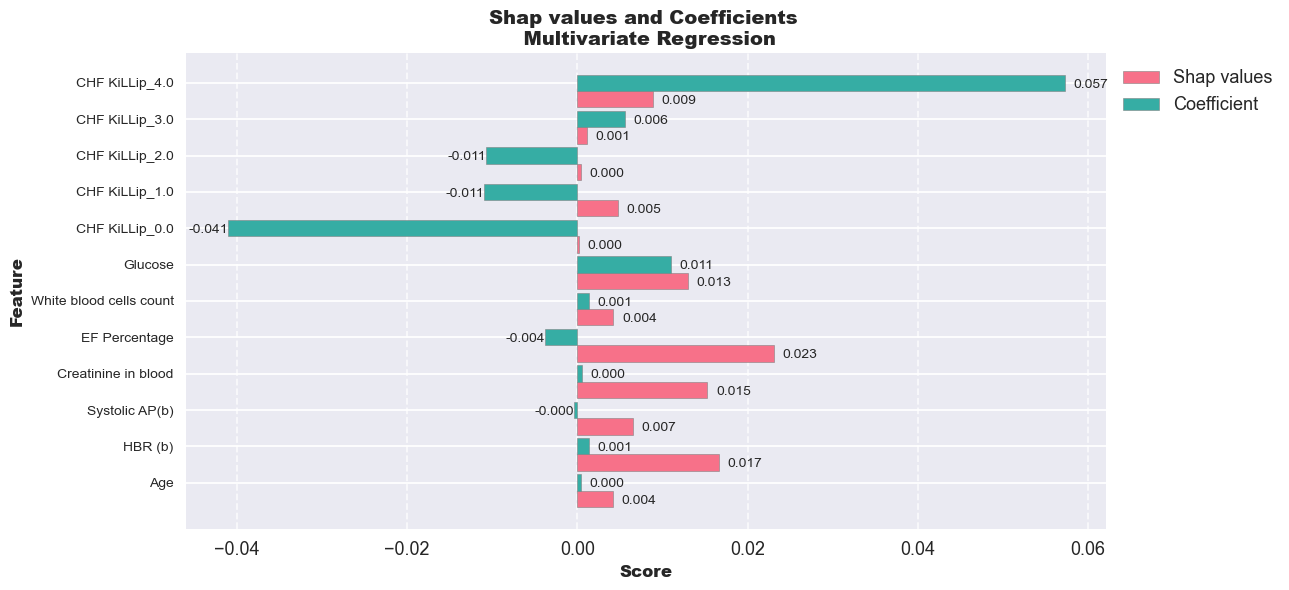

In [97]:
plot_weights(feature_importances_multi, 
             'Mean shap values', 
             'Coef', 
             label1='Shap values', 
             label2='Coefficient', 
             title='Shap values and Coefficients \n Multivariate Regression', 
             num_digits = 3 )

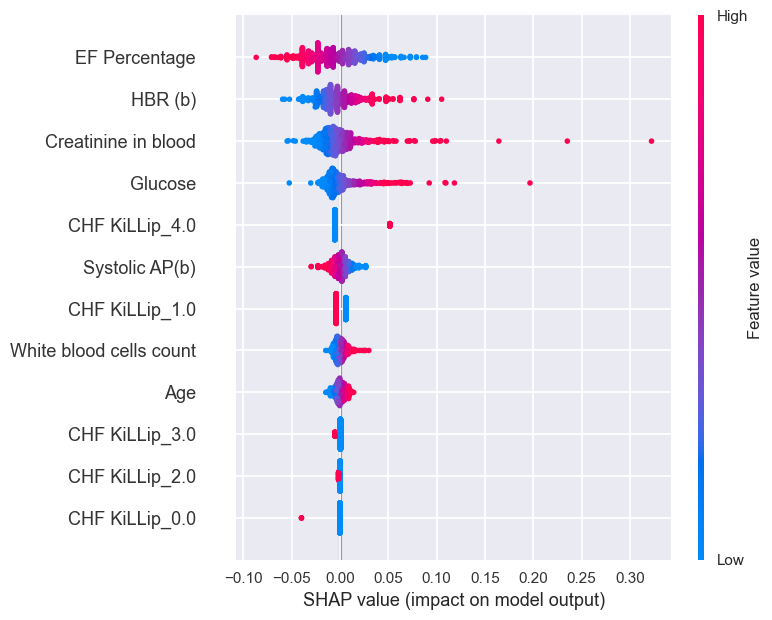

In [106]:
shap.summary_plot(shap_values.values, X_global_test, feature_names=feature_names, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

# VI. Conclusion